In [53]:
# ISYE 6740 Homework 1

import numpy as np
import numpy.matlib
from skimage import io
from matplotlib import pyplot as plt
import random
import scipy.misc
import scipy.spatial.distance as sc


In [54]:
#Randomly pick the medoids
def init_medoids(X,K):
    c = random.sample(list(X),K)
    return c

In [55]:
#We use the Euclidian distance to find the closest medoid
#WIKI:In Cartesian coordinates, if p = (p1, p2,..., pn) and q = (q1, q2,..., qn) are 
#two points in Euclidean n-space, then the distance (d) from p to q, or from q to p is given by 
#the Pythagorean formula
def assign_points_to_medoids(X,medoids):
    K = np.size(medoids,0)
    #Each round we use arr to track each points distance from each medoids
    #The array idx will contain index of the medoid with that the point has min distance
    #For each medoid, there is one column. The function argmin picks the min column and return the index (medoid ID)
    idx = np.zeros((np.size(X,0),1))
    arr = np.empty((np.size(X,0),1))

    for i in range(0,K):
        medoid = medoids[i] #pick the first medoid
        temp = np.ones((np.size(X,0),1))*medoid #the * will replaces 1 with the an array of RGB
        temp = np.power(np.subtract(X,temp),2) #we are using the euclidian distance. do (x-medoid)^2 
        temp = np.sum(temp,axis = 1)#Do the summation of pythagorean formula  
        temp.resize((np.size(X,0),1)) #The np.sum gives horizontal array. We need to resize it.
        #print(np.shape(a))
        arr = np.append(arr, temp, axis=1)
        #print('shape arr for i={} '.format(i), arr.shape)

    arr = np.delete(arr,0,axis=1)
    idx = np.argmin(arr, axis=1) #The np.argmin give horizontal array
    #print('shape of idx at the end ' , np.shape(idx))
    return idx

In [56]:
#This function does the adjustments.
#This is what differs kmeans to kmedoids
def adjust_medoids(X,idx,K):
    n = np.size(X,1) #Number of columns. In our case is always 3 (RGB)
    medoids = np.zeros((K,n))
    for i in range(0,K):
        medoid = idx==i #Select point only those under medoid i
        cluster = X[medoid] #Those points are this cluster
        cluster = np.unique(cluster, axis=0) #advice from piazza (classmates). It really helpped. 
        minMediod = np.zeros((1, n)) #an array variable to contain the min medoid for this cluster
        minDissimilarity = float("inf") #a variable that contains the min dissimilarity for this cluster
        for data in cluster:
            candidateMedoid = data
            temp = np.ones((np.size(cluster,0),1))*data
            temp = np.power(np.subtract(cluster,temp),2)
            temp = np.sum(temp,axis = 1)
            dissimilarity = np.sum(temp) 
            if dissimilarity < minDissimilarity : #here we pick the medoid that other points has min dissimilarity
                minMediod = data
                minDissimilarity = dissimilarity
            
        medoids[i] = minMediod
        
    return medoids

In [57]:
#This function does the adjustments.
#This is what differs kmeans to kmedoids
def adjust_medoids2(X,idx,K):
    n = np.size(X,1) #Number of columns. In our case is always 3 (RGB)
    medoids = np.zeros((K,n))
    for i in range(0,K):
        medoid = idx==i #Select point only those under medoid i
        cluster = X[medoid] #Those points are this cluster
        if (cluster.size == 0): break
        temp = np.unique(cluster, axis=0)
        temp = sc.pdist(temp, 'euclidean')
        temp = sc.squareform(temp)
        temp = temp.sum(axis=1)
        min_indx = np.argmin(temp, axis=0)
        medoids[i] = cluster[min_indx]
        
    return medoids

In [58]:
#we have two conditions to stop the run. max_iters and if medoid did not change from one itr to another.
def has_converged (old_medoids, new_medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in new_medoids])

#the main body of the algorithm
def kMedoid(X,initial_medoids,max_iters):
    m = np.size(X,0) #number of columns. in this case is 3
    n = np.size(X,1) #number of rows
    K = np.size(initial_medoids,0)
    medoids = initial_medoids
    previous_medoids = medoids
    idx = np.zeros((m,1))
    for i in range(1,max_iters):
        #print('iteration number: ', i)
        idx = assign_points_to_medoids(X,medoids)
        medoids = adjust_medoids2(X,idx,K)
        if has_converged(previous_medoids, medoids):
            break
            
    return medoids,idx

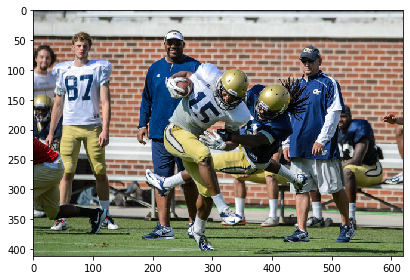

In [59]:
imageName='football.bmp'

image = io.imread(imageName)
io.imshow(image)
io.show()

In [60]:
#We will use this data to reconstruct the image later on
rows = image.shape[0]
cols = image.shape[1]
print('rows x cols = ',rows,'X',cols)

#We can scale the data but I don't see any point to it.
image = image/255

#Let's make the image one long column of three information (RBG) 
#I like to name my data 'data' but looks like in data science world,they always use X
X = image.reshape(image.shape[0]*image.shape[1],3)
#Number of clusters
K = 16 

#Number of times the k-mean should run
#We have two mechanism to stop the run: max_iters and comparison of medoids
max_iters = 50 

initial_medoids = init_medoids(X,K)
medoids,idx = kMedoid(X,initial_medoids,max_iters)
print('shape of the medoids', np.shape(medoids))
print('shape of index or class', np.shape(idx))

new_X = medoids[idx]
print('shape of the compressed image in one column', np.shape(new_X))
new_X = np.reshape(new_X, (rows, cols, 3))
print('shape of the compressed image in RGB', np.shape(new_X))

rows x cols =  412 X 620
shape of the medoids (16, 3)
shape of index or class (255440,)
shape of the compressed image in one column (255440, 3)
shape of the compressed image in RGB (412, 620, 3)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


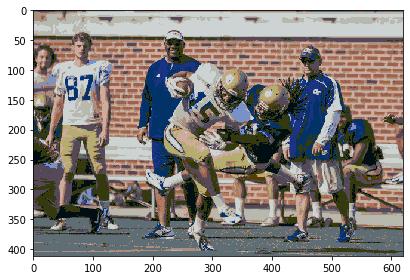

In [61]:
import imageio
imageio.imwrite('kmedoid'+str(K)+'-'+imageName, new_X)

image_compressed = io.imread('kmedoid'+str(K)+'-'+imageName)
io.imshow(image_compressed)
io.show()


In [62]:
import os
info = os.stat(imageName)
print("The size of the original image: ",info.st_size/1024,"KB")
info = os.stat('kmedoid'+str(K)+'-'+imageName)
print("The size of the compressed image: ",info.st_size/1024,"KB")

The size of the original image:  748.412109375 KB
The size of the compressed image:  748.412109375 KB


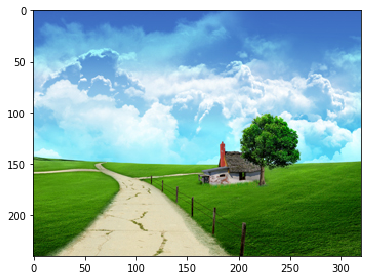

In [63]:
imageName='pic.bmp'

image = io.imread(imageName)
io.imshow(image)
io.show()

In [64]:
import time
start = time.time()

rows = image.shape[0]
cols = image.shape[1]
print('rows x cols = ',rows,'X',cols)


image = image/255


X = image.reshape(image.shape[0]*image.shape[1],3)
K = 20 

max_iters = 50 

initial_medoids = init_medoids(X,K)
medoids,idx = kMedoid(X,initial_medoids,max_iters)
print('shape of the medoids', np.shape(medoids))
print('shape of index or class', np.shape(idx))

new_X = medoids[idx]
print('shape of the compressed image in one column', np.shape(new_X))
new_X = np.reshape(new_X, (rows, cols, 3))
print('shape of the compressed image in RGB', np.shape(new_X))

print ("it took", time.time() - start, "seconds. or ", (time.time() - start)/60, " min")

rows x cols =  240 X 320
shape of the medoids (20, 3)
shape of index or class (76800,)
shape of the compressed image in one column (76800, 3)
shape of the compressed image in RGB (240, 320, 3)
it took 23.83195972442627 seconds. or  0.3971993327140808  min


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


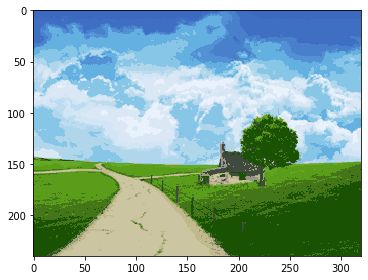

In [65]:
import imageio
imageio.imwrite('kmedoid'+str(K)+'-'+imageName, new_X)

image_compressed = io.imread('kmedoid'+str(K)+'-'+imageName)
io.imshow(image_compressed)
io.show()


In [66]:
import os
info = os.stat(imageName)
print("The size of the original image: ",info.st_size/1024,"KB")
info = os.stat('kmedoid'+str(K)+'-'+imageName)
print("The size of the compressed image: ",info.st_size/1024,"KB")

The size of the original image:  225.052734375 KB
The size of the compressed image:  225.052734375 KB


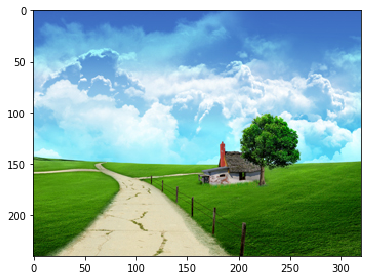

In [67]:
imageName='pic.bmp'

image = io.imread(imageName)
io.imshow(image)
io.show()

In [68]:
import time
start = time.time()

rows = image.shape[0]
cols = image.shape[1]
print('rows x cols = ',rows,'X',cols)


image = image/255


X = image.reshape(image.shape[0]*image.shape[1],3)
K = 15 

max_iters = 50 

initial_medoids = init_medoids(X,K)
medoids,idx = kMedoid(X,initial_medoids,max_iters)
print('shape of the medoids', np.shape(medoids))
print('shape of index or class', np.shape(idx))

new_X = medoids[idx]
print('shape of the compressed image in one column', np.shape(new_X))
new_X = np.reshape(new_X, (rows, cols, 3))
print('shape of the compressed image in RGB', np.shape(new_X))

print ("it took", time.time() - start, "seconds. or ", (time.time() - start)/60, " min")

rows x cols =  240 X 320
shape of the medoids (15, 3)
shape of index or class (76800,)
shape of the compressed image in one column (76800, 3)
shape of the compressed image in RGB (240, 320, 3)
it took 25.383087396621704 seconds. or  0.4230514645576477  min


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


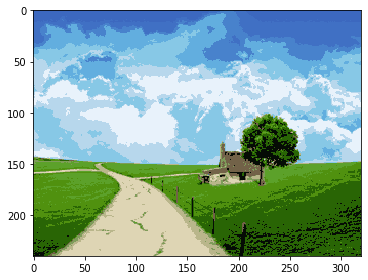

In [69]:
import imageio
imageio.imwrite('kmedoid'+str(K)+'-'+imageName, new_X)

image_compressed = io.imread('kmedoid'+str(K)+'-'+imageName)
io.imshow(image_compressed)
io.show()


In [70]:
import os
info = os.stat(imageName)
print("The size of the original image: ",info.st_size/1024,"KB")
info = os.stat('kmedoid'+str(K)+'-'+imageName)
print("The size of the compressed image: ",info.st_size/1024,"KB")

The size of the original image:  225.052734375 KB
The size of the compressed image:  225.052734375 KB


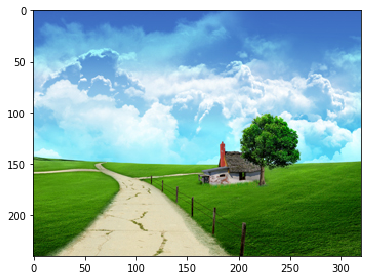

In [71]:
imageName='pic.bmp'

image = io.imread(imageName)
io.imshow(image)
io.show()

In [72]:
import time
start = time.time()

rows = image.shape[0]
cols = image.shape[1]
print('rows x cols = ',rows,'X',cols)


image = image/255


X = image.reshape(image.shape[0]*image.shape[1],3)
K = 10 

max_iters = 50 

initial_medoids = init_medoids(X,K)
medoids,idx = kMedoid(X,initial_medoids,max_iters)
print('shape of the medoids', np.shape(medoids))
print('shape of index or class', np.shape(idx))

new_X = medoids[idx]
print('shape of the compressed image in one column', np.shape(new_X))
new_X = np.reshape(new_X, (rows, cols, 3))
print('shape of the compressed image in RGB', np.shape(new_X))

print ("it took", time.time() - start, "seconds. or ", (time.time() - start)/60, " min")

rows x cols =  240 X 320
shape of the medoids (10, 3)
shape of index or class (76800,)
shape of the compressed image in one column (76800, 3)
shape of the compressed image in RGB (240, 320, 3)
it took 41.058647871017456 seconds. or  0.6843108057975769  min


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


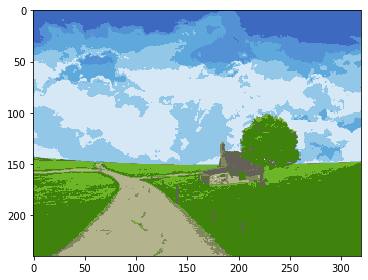

In [73]:
import imageio
imageio.imwrite('kmedoid'+str(K)+'-'+imageName, new_X)

image_compressed = io.imread('kmedoid'+str(K)+'-'+imageName)
io.imshow(image_compressed)
io.show()


In [74]:
import os
info = os.stat(imageName)
print("The size of the original image: ",info.st_size/1024,"KB")
info = os.stat('kmedoid'+str(K)+'-'+imageName)
print("The size of the compressed image: ",info.st_size/1024,"KB")

The size of the original image:  225.052734375 KB
The size of the compressed image:  225.052734375 KB


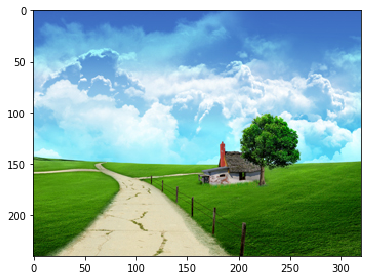

In [75]:
imageName='pic.bmp'

image = io.imread(imageName)
io.imshow(image)
io.show()

In [76]:
import time
start = time.time()

rows = image.shape[0]
cols = image.shape[1]
print('rows x cols = ',rows,'X',cols)


image = image/255


X = image.reshape(image.shape[0]*image.shape[1],3)
K = 5 

max_iters = 50 

initial_medoids = init_medoids(X,K)
medoids,idx = kMedoid(X,initial_medoids,max_iters)
print('shape of the medoids', np.shape(medoids))
print('shape of index or class', np.shape(idx))

new_X = medoids[idx]
print('shape of the compressed image in one column', np.shape(new_X))
new_X = np.reshape(new_X, (rows, cols, 3))
print('shape of the compressed image in RGB', np.shape(new_X))

print ("it took", time.time() - start, "seconds. or ", (time.time() - start)/60, " min")

rows x cols =  240 X 320
shape of the medoids (5, 3)
shape of index or class (76800,)
shape of the compressed image in one column (76800, 3)
shape of the compressed image in RGB (240, 320, 3)
it took 92.49291729927063 seconds. or  1.5415486335754394  min


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


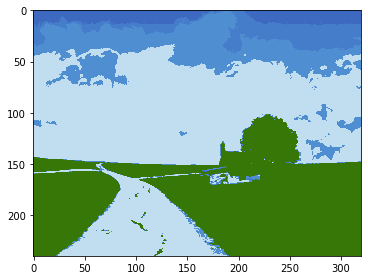

In [77]:
import imageio
imageio.imwrite('kmedoid'+str(K)+'-'+imageName, new_X)

image_compressed = io.imread('kmedoid'+str(K)+'-'+imageName)
io.imshow(image_compressed)
io.show()


In [78]:
import os
info = os.stat(imageName)
print("The size of the original image: ",info.st_size/1024,"KB")
info = os.stat('kmedoid'+str(K)+'-'+imageName)
print("The size of the compressed image: ",info.st_size/1024,"KB")

The size of the original image:  225.052734375 KB
The size of the compressed image:  225.052734375 KB
